In [1]:
from __future__ import division
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.special as spec
from numpy import random
from scipy.interpolate import interp1d

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
matplotlib.rcParams.update({'font.size':15})
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = [5,3]
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
from scipy.stats import ncx2
# 1DOF, lambda=mu**2
# y = ncx2.pdf(Lambda, 1, lambda)

In [4]:
# useful routine for finding array element nearest to desired value
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if np.abs(value - array[idx-1]) < np.abs(value - array[idx]):
        return idx-1, array[idx-1]
    else:
        return idx, array[idx]

In [5]:
# set some parameters

# noise variance and number of time samples
sigma = 1.0
N = 100
sigma_ahat = sigma/np.sqrt(N)

# range of parameter arrays
a_max = 1.0
Lambda_max = 30.0

# injected signal strength
a0 = 0.1
a0 = 0.2

injected amplitude =  0.2
sample mean =  0.23511228312543653
ahat =  0.23511228312543653
detection statistic =  5.527778567645542


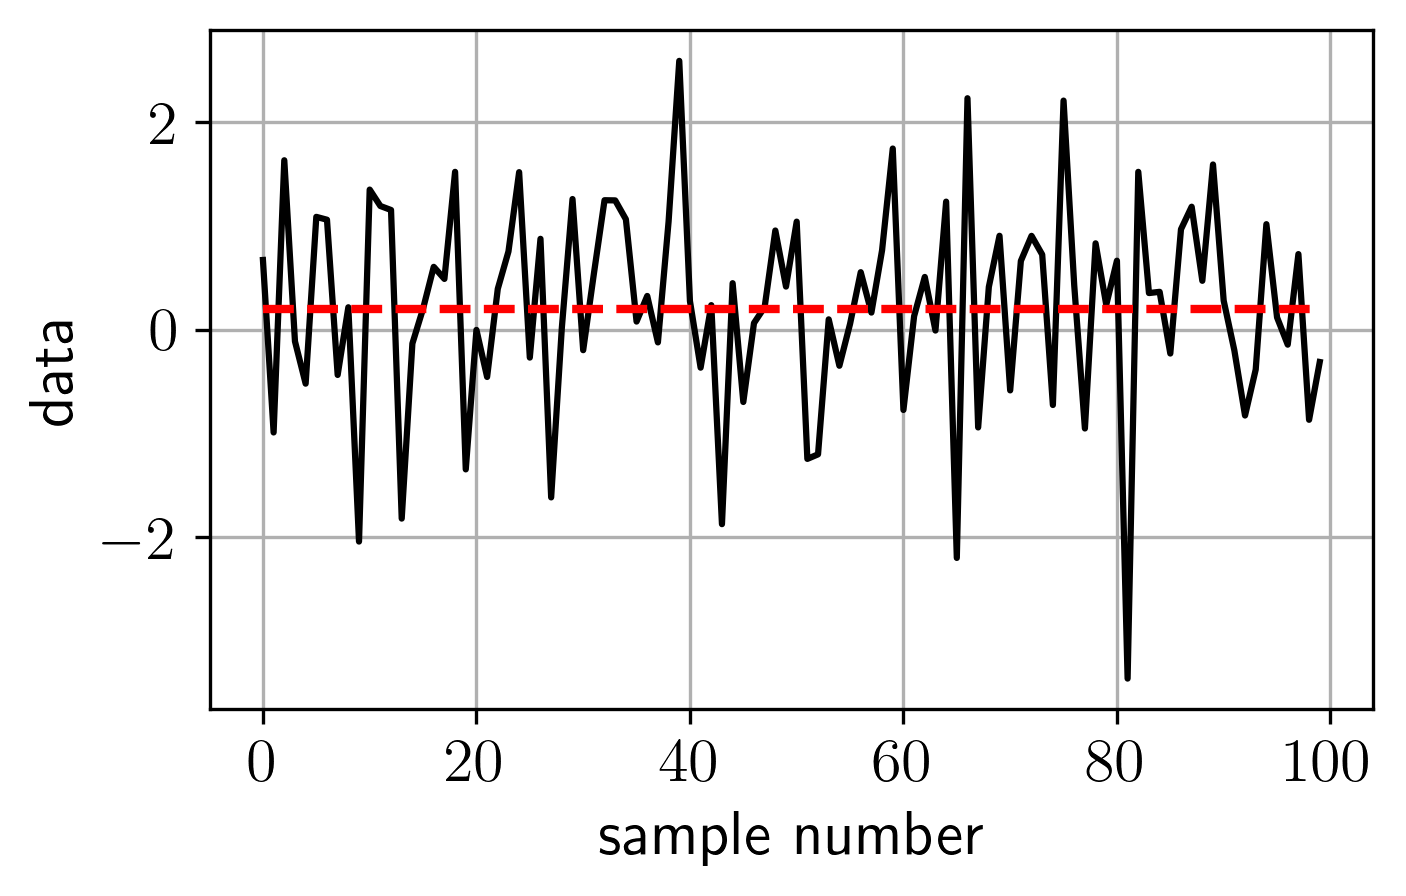

In [6]:
# simulate data

# generate random samples
random.seed(1234)
n = random.normal(0, sigma, N)
s = a0 * np.ones(N)
d = n + s
print('injected amplitude = ', a0)

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(d, color='k')
plt.plot(s, color='red', linestyle='dashed', linewidth=2)
#plt.title(r'$a_0=$' + repr(a0))
plt.xlabel('sample number')
plt.ylabel('data')
plt.grid()
plt.savefig('./example-simulated-data.pdf', bbox_inches='tight', dpi=400)

# calculate sample mean and detection statistic value
dbar = np.mean(d)
ahat = dbar
print('sample mean = ', dbar)
print('ahat = ', ahat)

Lambda0 = dbar**2/(sigma**2/N)
print('detection statistic = ', Lambda0)

In [7]:
# parameter arrays (detection statistic and amplitude a)
Ns = 1000
a = np.linspace(0.0, a_max, Ns)
Lambda = np.linspace(0.05, Lambda_max, Ns)
mu = a*np.sqrt(N)/sigma

# differentials
dLambda = Lambda[1]-Lambda[0]
da = a[1]-a[0]

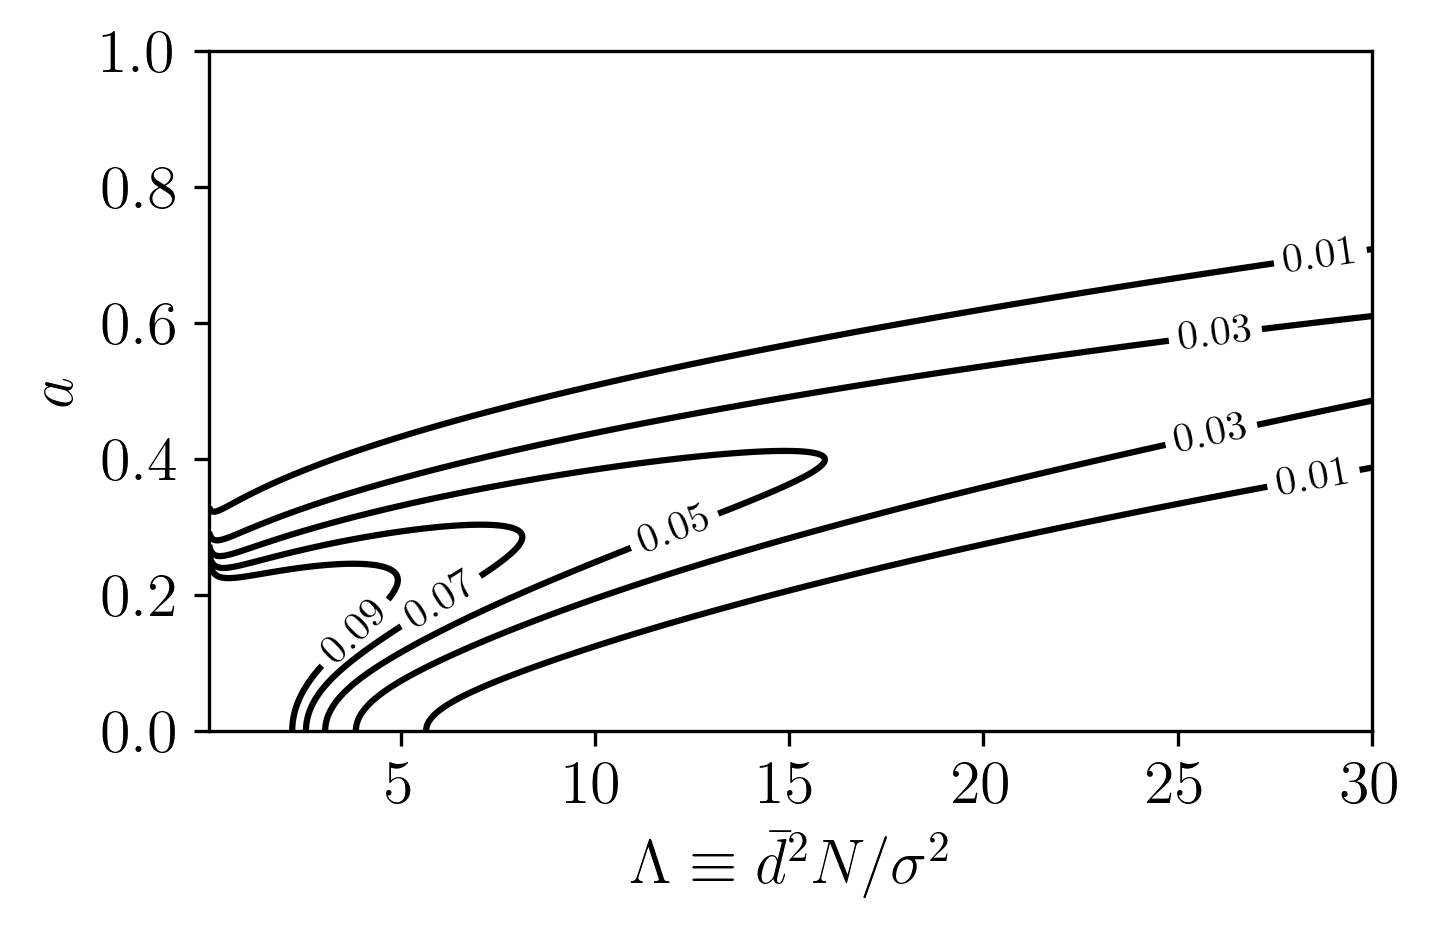

In [8]:
# calculate probability distribution for detection statistic for models M0 and M1

X, Y = np.meshgrid(Lambda, a)
Z = np.zeros((Ns, Ns))

for ii in range(0,Ns):
    for jj in range(0,Ns):
        
        # detection statistic value
        Lam = X[ii,jj]
  
        # non-centrality parameter
        #mu = Y[ii,jj]**2
        lam = Y[ii,jj]**2 * N/sigma**2
        
        # probability distribution
        if lam==0:
            Z[ii,jj] = (1./(np.sqrt(2.) * sp.special.gamma(0.5))) \
            * (Lam**(-0.5)) * np.exp(-Lam/2.)
        else:
            Z[ii,jj] = 0.5 * np.exp(-(Lam+lam)/2.) * np.power(Lam/lam, -0.25) \
            * sp.special.iv(-0.5, np.sqrt(lam*Lam))
            
        
# Create a simple contour plot with labels 
plt.figure()
plt.rc('text', usetex=True)
#V = np.logspace(np.log10(0.01), np.log10(0.1), 5)
V = np.linspace(0.01, 0.09, 5)
CS = plt.contour(X, Y, Z, V, colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel(r'$\Lambda\equiv\bar d^2 N/\sigma^2$')
plt.ylabel(r'$a$')
plt.savefig('./example-plambdaA.pdf', bbox_inches='tight', dpi=400)

In [9]:
# calculate noise-only sampling distribution for detection statistic
#prob0 = np.zeros(Ns)
#for ii in range(0, Ns):
#    prob0[ii] = (1./(np.sqrt(2.)*sp.special.gamma(0.5))) \
#    *(Lambda[ii]**(-0.5))*np.exp(-Lambda[ii]/2.)
prob0 = Z[0,:]

# calculate cumulative distribution by summing p0(lambda)dlambda
temp0 = np.cumsum(prob0 * dLambda)

# normalize
CDF0 = temp0/temp0[-1]

threshold for detection statistic =  2.9580580580580578


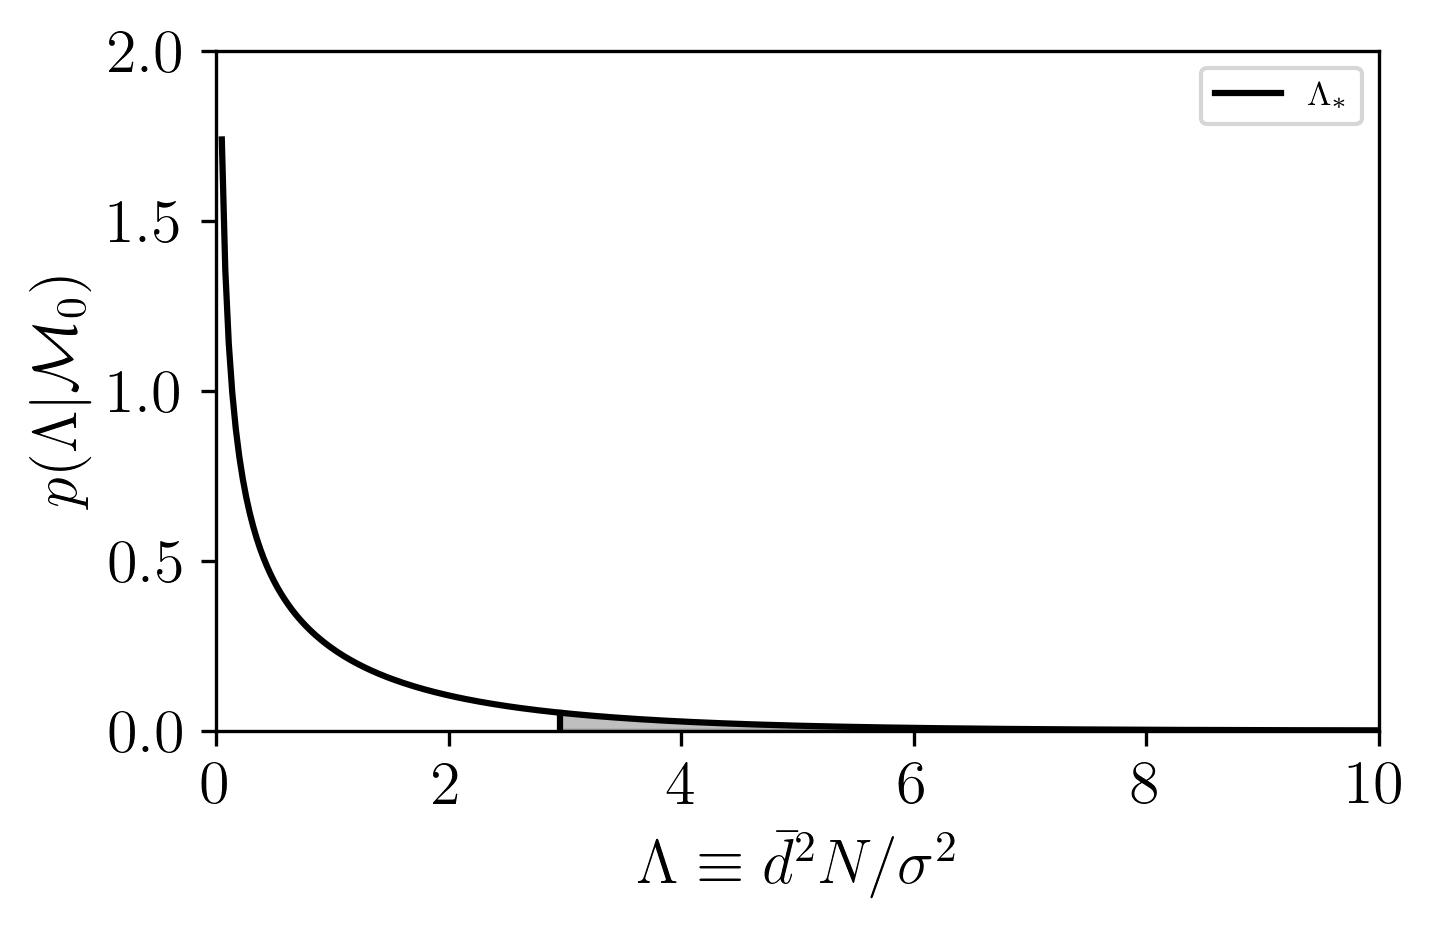

In [10]:
# calculate detection threshold (10% false alarm probability) for frequentist statistic
alpha = 0.10
idx_thres, val = find_nearest(CDF0, 1.0-alpha)
Lambda_thres = Lambda[idx_thres]
print('threshold for detection statistic = ', Lambda_thres)

# plot probability curve and threshold for detection statistic
fig = plt.figure()
ax = fig.add_subplot(111)
plt.rc('text', usetex=True)
plt.plot(Lambda, prob0, color='k')
plt.plot((Lambda_thres, Lambda_thres), (0, prob0[idx_thres]), color='k', label=r'$\Lambda_*$')
plt.xlabel(r'$\Lambda\equiv \bar d^2 N/\sigma^2$')
plt.ylabel(r'$p(\Lambda|{\cal M}_0)$')
plt.fill_between(Lambda, np.zeros(Ns), prob0, where=Lambda>=Lambda_thres, color='grey', alpha=0.5)
plt.xlim(0,10)
plt.ylim(0,2)
#plt.axhline(0, color='grey', lw=1)
plt.legend(fontsize=8)
plt.savefig('./example-detectionthreshold.pdf', bbox_inches='tight', dpi=400)

a for 90% detection probability =  0.3003003003003003


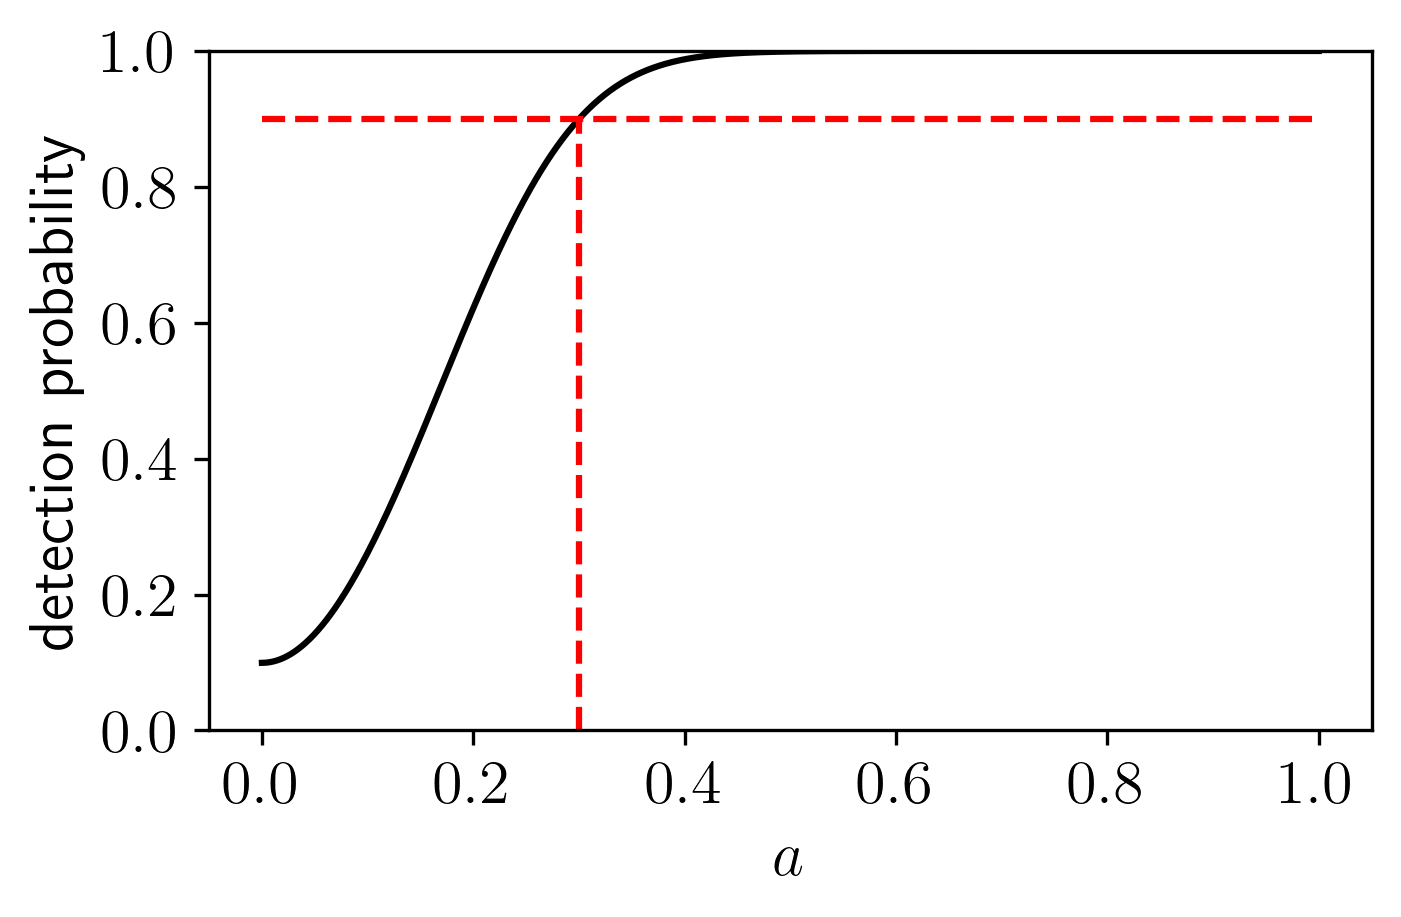

In [11]:
# calculate frequentist detection probability 

# now calculate detection probability 
DP = np.zeros(Ns)
for ii in range(0,Ns):
    probA = Z[ii, :]
    tempA = np.cumsum(probA * dLambda)
    CDFA = tempA/tempA[-1]
    
    DP[ii] = CDFA[-1] - CDFA[idx_thres]
    
# find 90% detection probability (for 10% false alarm)
idx_DP, val = find_nearest(DP, 0.90)
a_DP = a[idx_DP]
print('a for 90% detection probability = ', a_DP)

# plot detection probability curve
plt.figure()
plt.plot(a, DP, color='k')
plt.plot((0, a[-1]), (0.90, 0.90), color='r', linestyle='dashed')
plt.plot((a_DP, a_DP), (0, 0.90), color='r', linestyle='dashed')
plt.xlabel(r'$a$')
plt.ylabel(r'detection probability')
plt.ylim((0, 1))
plt.savefig('./example-frequentist-DP.pdf', bbox_inches='tight', dpi=400)

p-value for detection statistic =  0.021712715253950132
threshold for detection statistic =  2.9580580580580578
detection statistic =  5.527778567645542


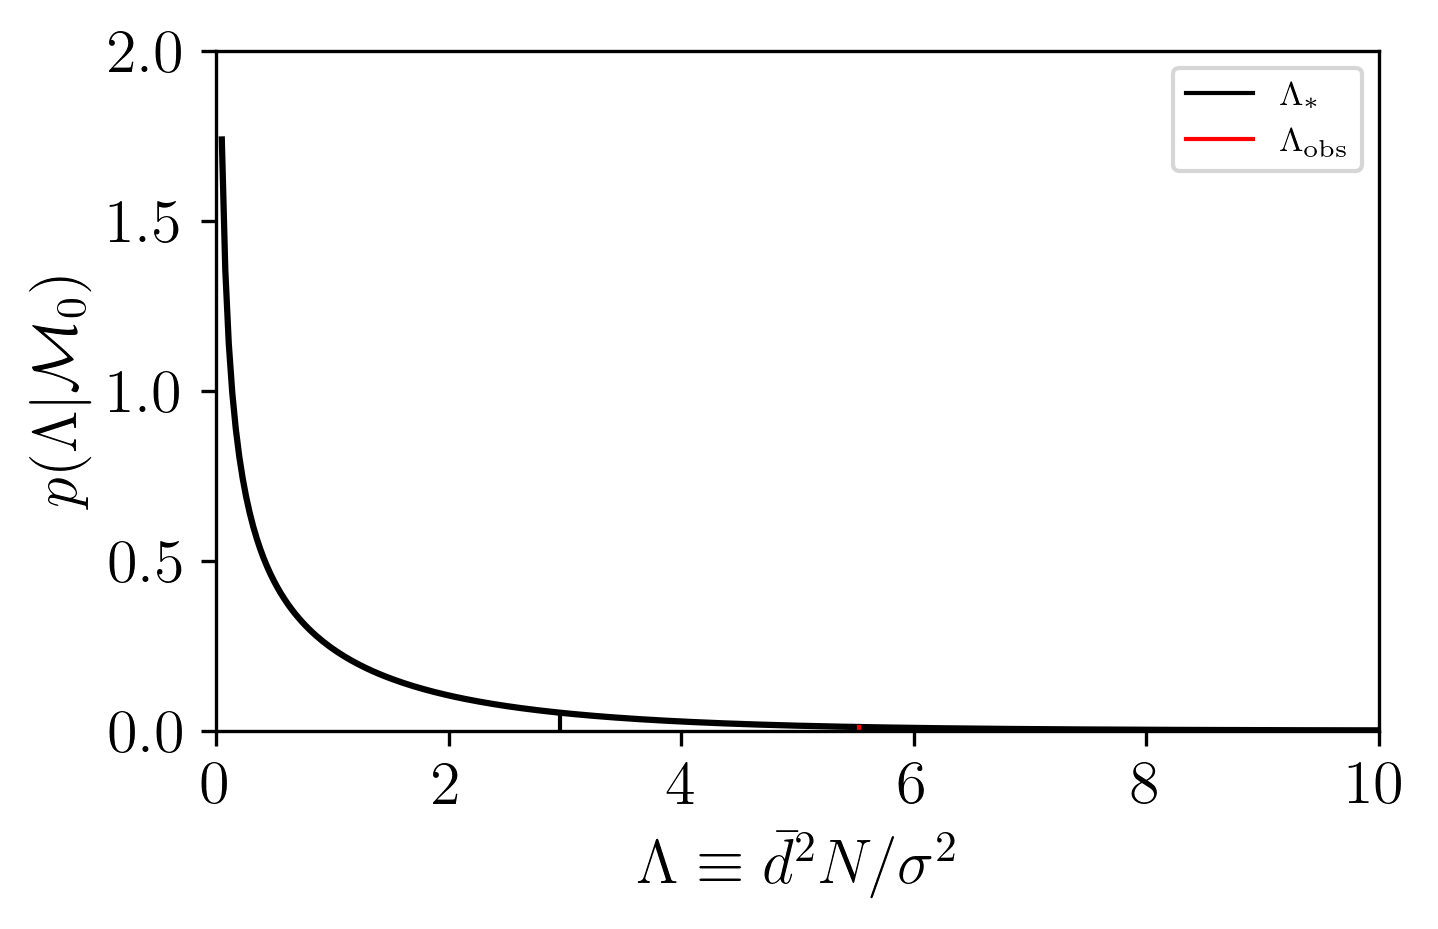

In [12]:
# calculate p-value for frequentist detection statistic
idx_p, val = find_nearest(Lambda, Lambda0)
pvalue = CDF0[-1] - CDF0[idx_p]
print('p-value for detection statistic = ', pvalue)
print('threshold for detection statistic = ', Lambda_thres)
print('detection statistic = ', Lambda0)

# plot probability curve, threshold, and p-value for detection statistic
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(Lambda, prob0, color='k')
plt.plot((Lambda_thres, Lambda_thres), (0, prob0[idx_thres]), color='k', linewidth=1, label=r'$\Lambda_*$')
plt.plot((Lambda0, Lambda0), (0, prob0[idx_p]), color='r', linewidth=1, label=r'$\Lambda_{\rm obs}$')
plt.xlabel(r'$\Lambda\equiv \bar d^2 N/\sigma^2$')
plt.ylabel(r'$p(\Lambda|{\cal M}_0)$')
plt.fill_between(Lambda, np.zeros(Ns), prob0, where=Lambda>=Lambda0, color='grey', alpha=0.5)
plt.xlim(0,10)
plt.ylim(0,2)
plt.legend(fontsize=8)
plt.savefig('./example-pvalue.pdf', bbox_inches='tight', dpi=400)

Frequentist UL on a =  0.36536536536536535


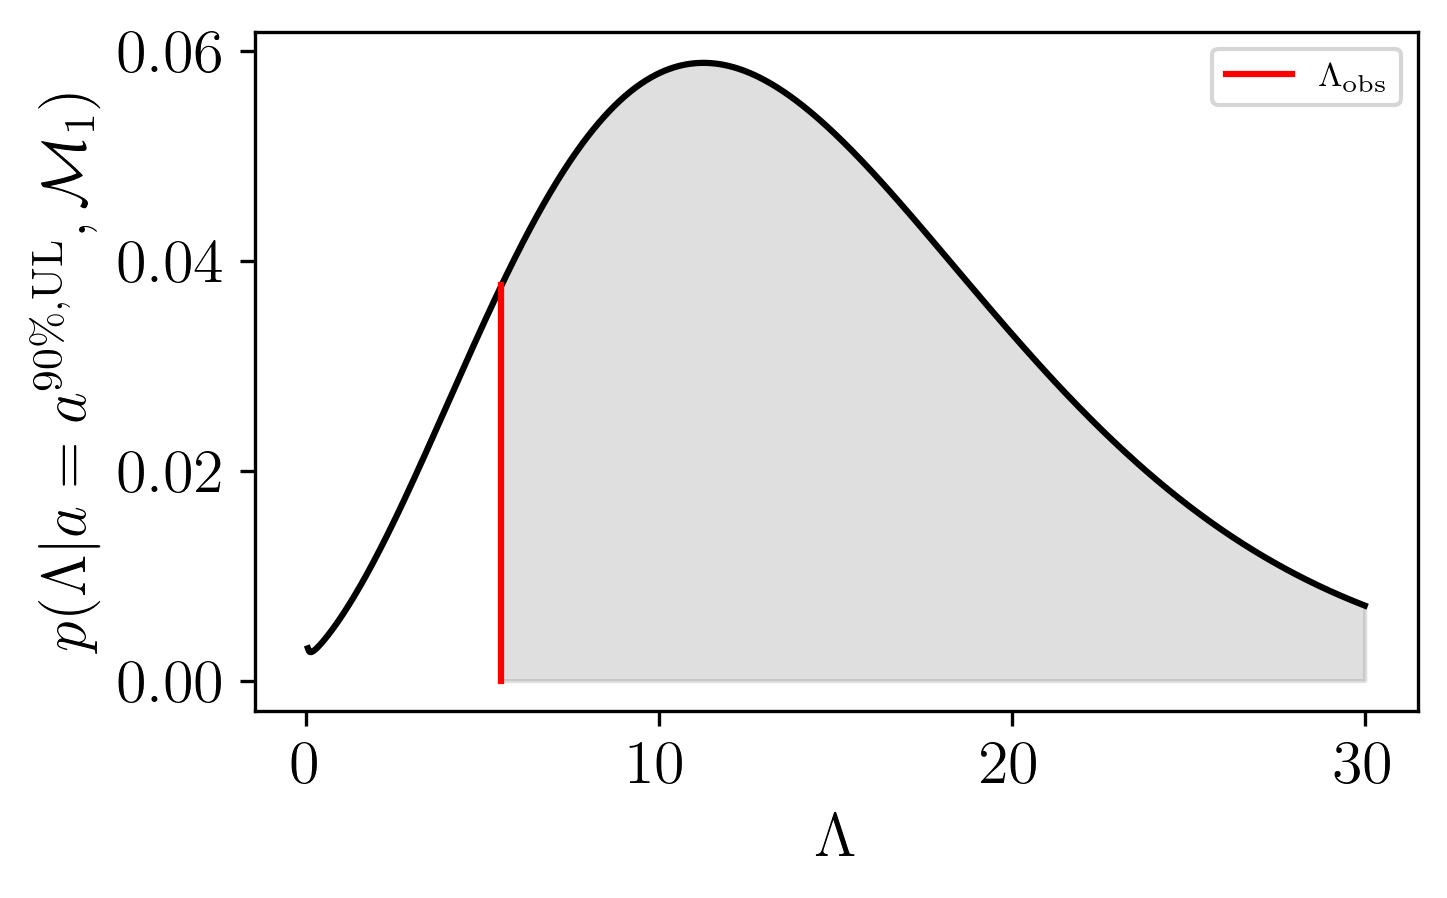

In [13]:
# calculate frequentist 90% confidence upper limit

# find idx for Lambda0
idx0, val = find_nearest(Lambda, Lambda0)

intprob = np.zeros(Ns)
# need to search over amplitudes a such that prob(Lambda>Lambda0|a) = .90
for ii in range(0, Ns):
    
    prob = Z[ii, :]
    temp = np.cumsum(prob * dLambda)
    
    PDF = prob/temp[-1]
    CDF = temp/temp[-1]
    
    # integrated probability from lamda0 to infty (actually max lambda0)
    intprob[ii] = CDF[-1] - CDF[idx0]
    
# calculate upper limit
idx_UL_freq, val = find_nearest(intprob, .90)
a_UL_freq = a[idx_UL_freq]
print('Frequentist UL on a = ', a_UL_freq)

# get probability distribution for a_UL
prob = Z[idx_UL_freq, :]
temp = np.cumsum(prob * dLambda)
PDF = prob/temp[-1]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(Lambda, PDF, color='k')
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$p(\Lambda|a=a^{90\%,{\rm UL}}, {\cal M}_1)$')
plt.plot((Lambda0,Lambda0), (0,PDF[idx0]), color='r',  label=r'$\Lambda_{\rm obs}$')

plt.fill_between(Lambda, np.zeros(Ns), PDF, where=Lambda>=Lambda0, color='grey', alpha=0.25)
plt.legend(fontsize=8)
plt.savefig('./example-frequentist-UL.pdf', bbox_inches='tight', dpi=400)

Frequentist 95% confidence interval on a: 0.035112283125436516 0.43511228312543654


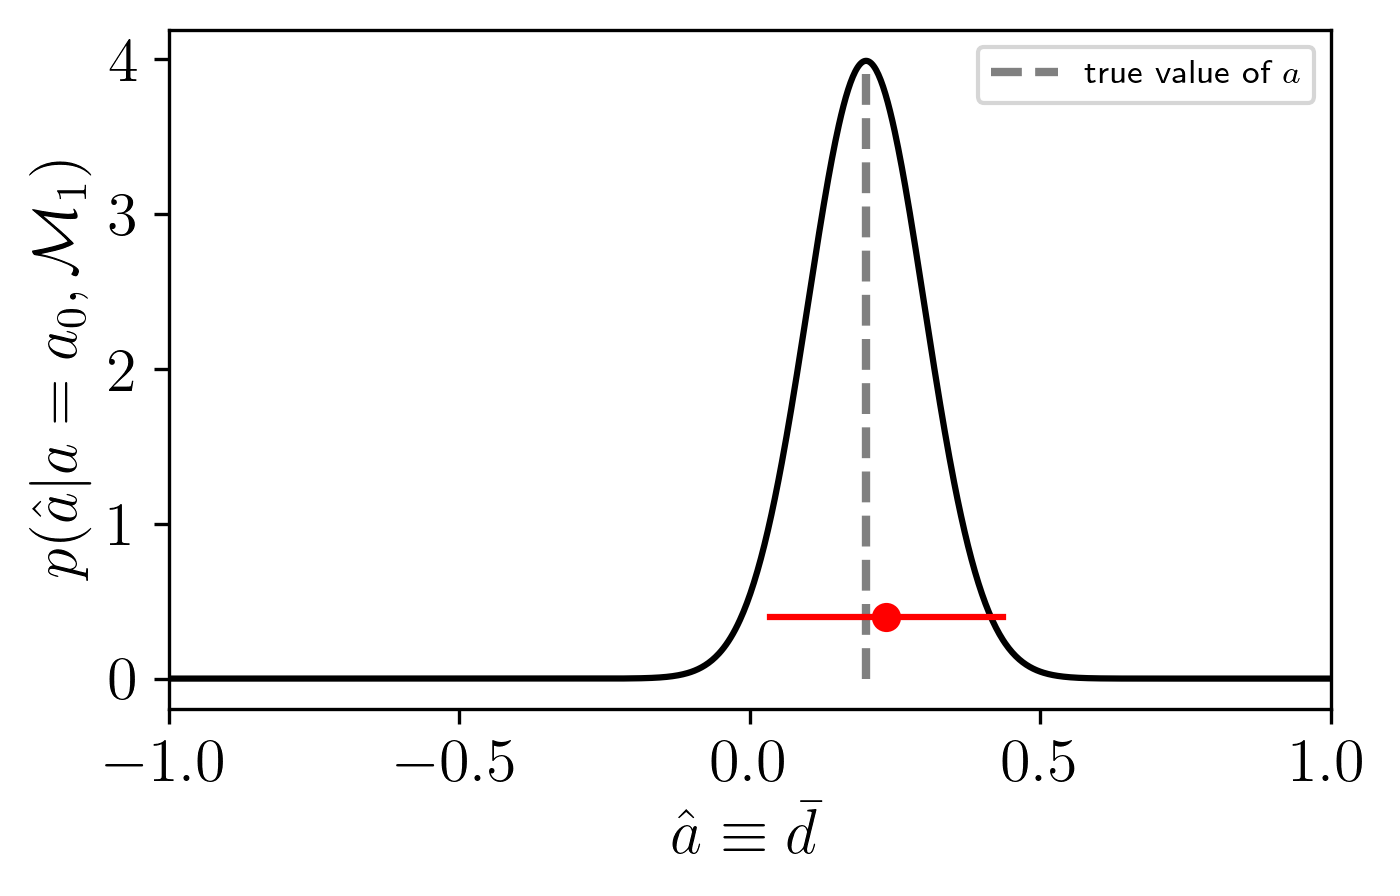

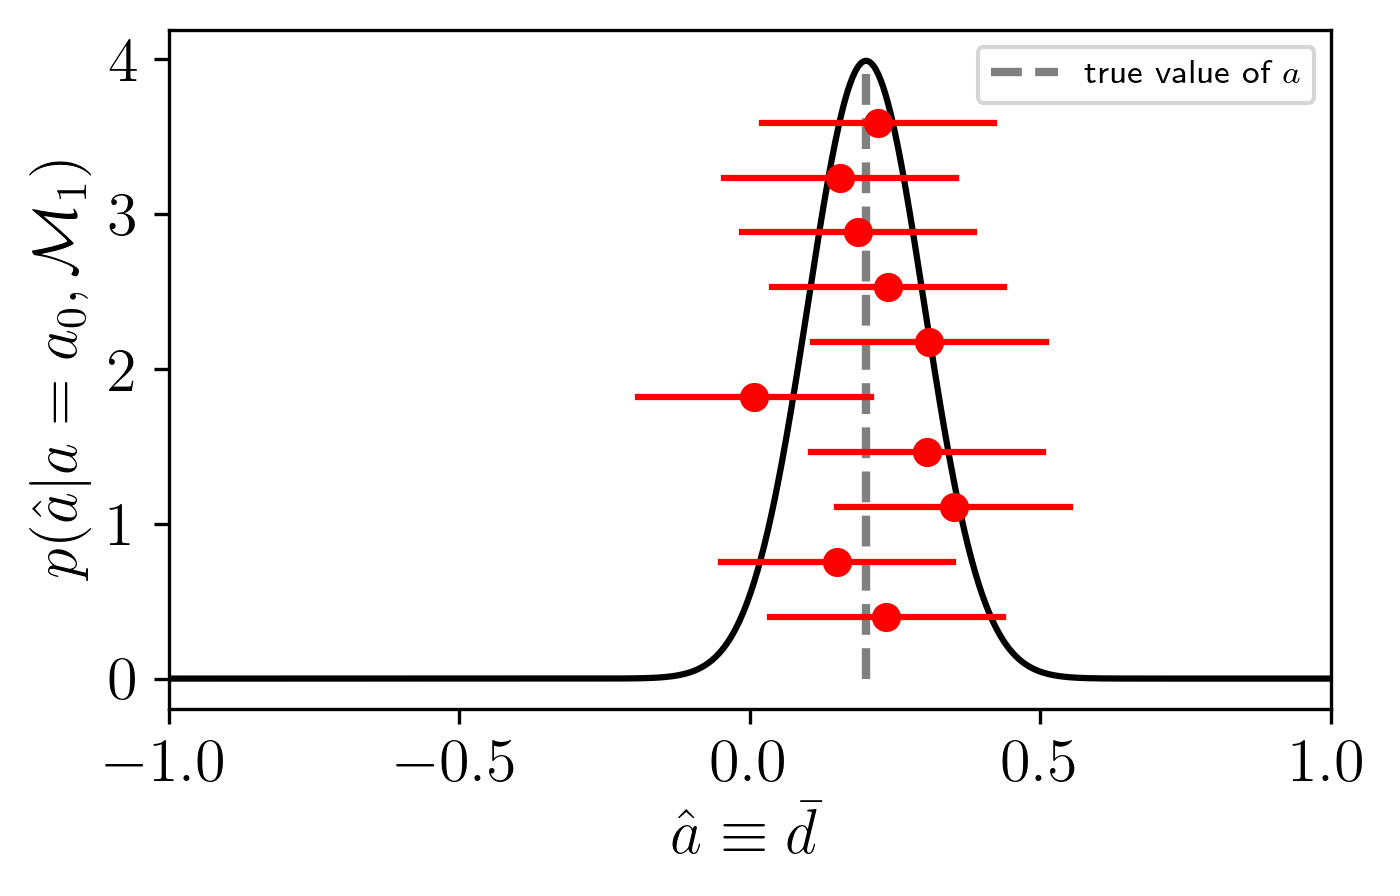

In [14]:
# frequentist parameter estimation

# maximum likelihood estimator of A is sample mean
aML = np.linspace(-a_max, a_max, Ns)

# probability distribution for ML estimator
prob_ML = (1.0/(np.sqrt(2*np.pi)*sigma_ahat)) * np.exp(-0.5*(aML - a0)**2/(sigma_ahat**2))
prob_ML_max = np.amax(prob_ML)
           
# plot probability distribution
plt.figure()
plt.plot(aML, prob_ML, color='k')
plt.xlabel(r'$\hat a \equiv \bar d$')
plt.ylabel(r'$p(\hat a|a=a_0, {\cal M}_1)$')

# add vertical line at injected value of A
idx_a0, val = find_nearest(aML, a0)
plt.plot((a0, a0), (0, prob_ML[idx_a0]), color='grey', linewidth=2, linestyle='dashed', label=r'true value of $a$')

# add 95% CL interval around ML estimate from data
ahat = dbar
plt.plot(ahat, 0.1*prob_ML_max, marker='o', color='r')
plt.plot((ahat-2.*sigma_ahat, ahat+2.*sigma_ahat), (0.1*prob_ML_max, 0.1*prob_ML_max), color='r')
plt.xlim((-a_max, a_max))
plt.legend(fontsize=8)
plt.savefig('./example-frequentist-interval.pdf', bbox_inches='tight', dpi=400)

print('Frequentist 95% confidence interval on a:', ahat-2*sigma_ahat, ahat+2*sigma_ahat)

################################################################
# generate a distribution of ML estimator values for simulated data
random.seed(1234)
Ntrials = 10
yval = np.linspace(0.1*prob_ML_max, 0.9*prob_ML_max, Ntrials)

# plot probability distribution
plt.figure()
plt.plot(aML, prob_ML, color='k')
plt.xlabel(r'$\hat a \equiv \bar d$')
plt.ylabel(r'$p(\hat a|a=a_0, {\cal M}_1)$')

# add vertical line at injected value of A
idx_a0, val = find_nearest(aML, a0)
plt.plot((a0, a0), (0, prob_ML[idx_a0]), color='grey', linewidth=2, linestyle='dashed', label=r'true value of $a$')

for ii in range(0, Ntrials):
    # generate random samples
    n = random.normal(0, sigma, N)
    s = a0 * np.ones(N)
    d = n + s

    # calculate 95% CL (2-sigma) intervals
    plt.plot(np.mean(d), yval[ii], marker='o', color='r')
    plt.plot((np.mean(d)-2.*sigma_ahat, np.mean(d)+2.*sigma_ahat), (yval[ii], yval[ii]), color='r')
    
plt.xlim((-a_max, a_max))
plt.legend(fontsize=8)
plt.savefig('./example-frequentist-intervals.pdf', bbox_inches='tight', dpi=400)

Bayesian UL on a =  0.36336336336336333


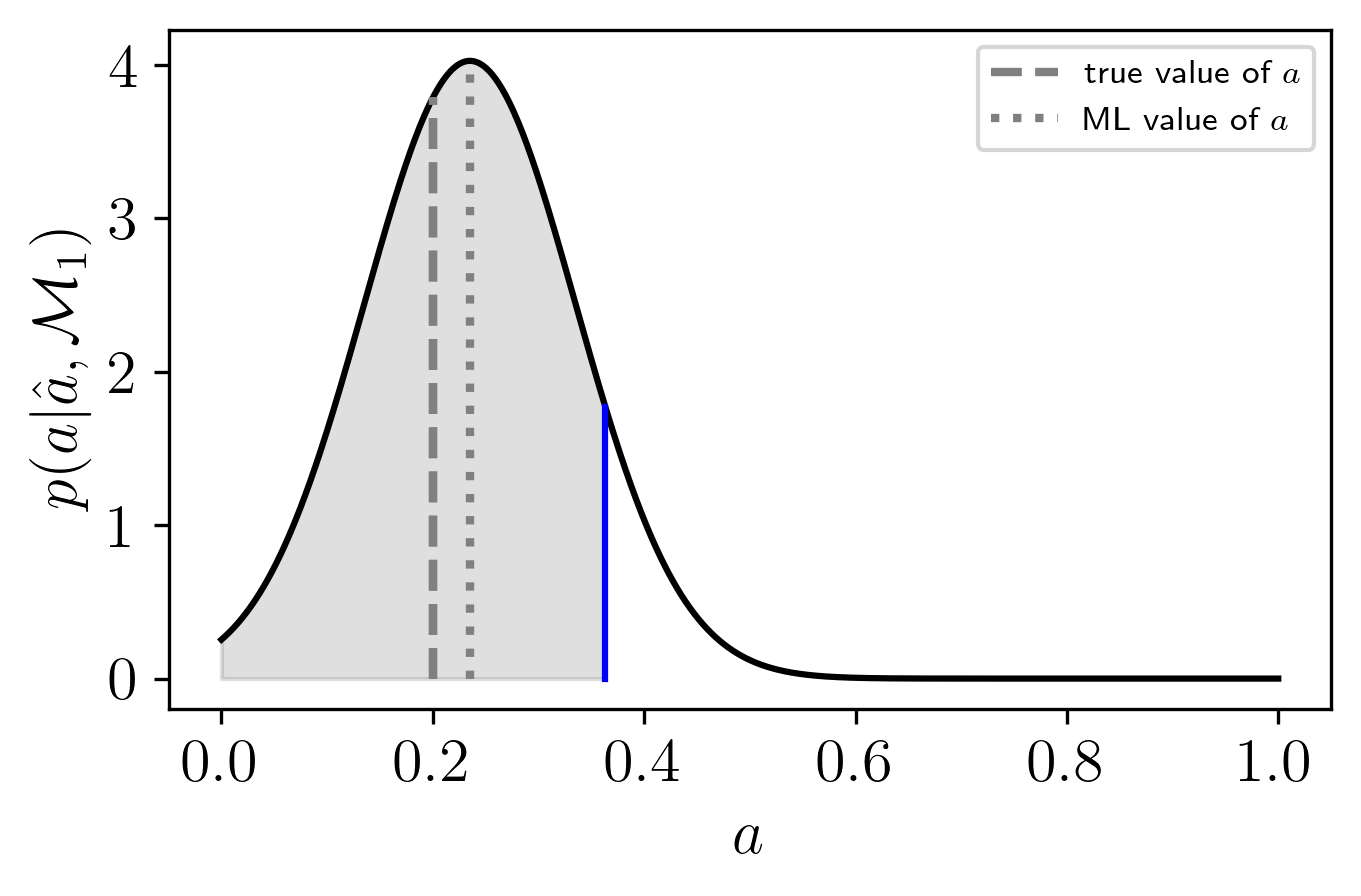

In [15]:
# calculate bayesian 90% confidence upper limit

# probability distribution based on maximum likelihood estimator of a
prob_a = (1.0/(np.sqrt(2*np.pi)*sigma_ahat)) * np.exp(-0.5*(a - ahat)**2/(sigma_ahat**2))

# renormalize probability distribution to allow for truncation
temp = np.cumsum(prob_a * da)
CDF = temp/temp[-1]
prob_a = prob_a/temp[-1]
    
# find 90% UL
idx_UL_bayes, val = find_nearest(CDF, 0.90)
a_UL_bayes = a[idx_UL_bayes]
print('Bayesian UL on a = ', a_UL_bayes)

# plot probability distribution
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(a, prob_a, color='k')
plt.xlabel(r'$a$')
plt.ylabel(r'$p(a|\hat a,{\cal M}_1)$')

# add vertical line at true value of a (not necessarily equal to ahat)
idx_a0, val = find_nearest(a, a0)
plt.plot((a0, a0), (0, prob_a[idx_a0]), color='grey', linewidth=2, linestyle='dashed', label=r'true value of $a$')

idx_ahat, val = find_nearest(a, ahat)
plt.plot((ahat, ahat), (0, prob_a[idx_ahat]), color='grey', linewidth=2, linestyle='dotted', label=r'ML value of $a$')

plt.plot((a_UL_bayes, a_UL_bayes), (0,prob_a[idx_UL_bayes]), color='b')
plt.plot((a0, a0), (0, prob_a[idx_a0]), color='grey', linewidth=2, linestyle='dashed')

plt.fill_between(a, np.zeros(Ns), prob_a, where=a<=a_UL_bayes, color='grey', alpha=0.25)
plt.legend(fontsize=8)
plt.savefig('./example-bayesian-UL.pdf', bbox_inches='tight', dpi=400)

Bayesian 95% confidence interval on a: 0.035035035035035036 0.43543543543543545


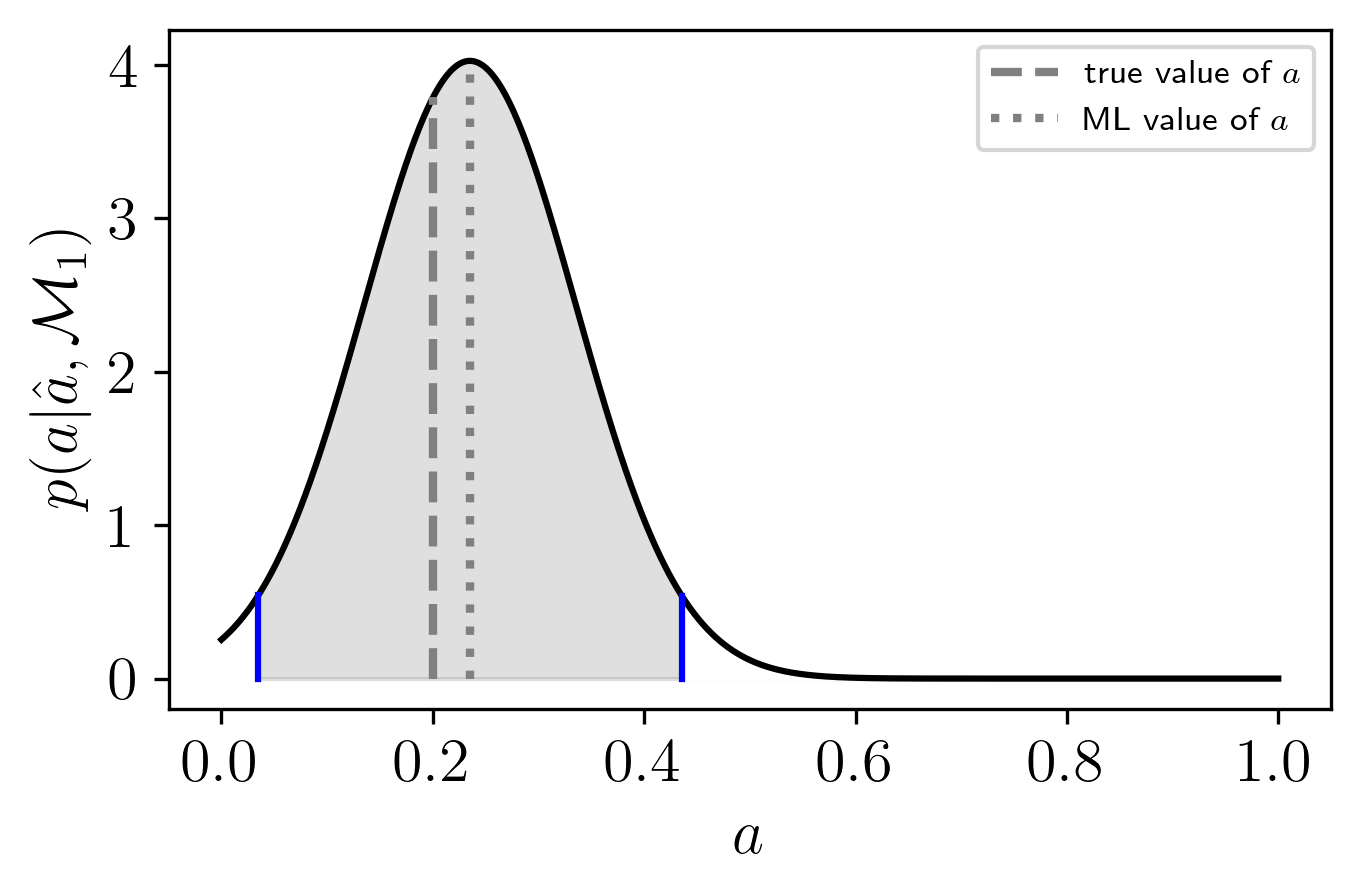

In [16]:
# bayesian parameter estimation

# probability distribution for a is *truncated* gaussian around sample mean
prob_a = (1.0/(np.sqrt(2*np.pi)*sigma_ahat)) * np.exp(-0.5*(a - ahat)**2/(sigma_ahat**2))

# renormalize probability distribution to allow for truncation
temp = np.cumsum(prob_a * da)
CDF = temp/temp[-1]
prob_a = prob_a/temp[-1]
    
# plot probability distribution
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(a, prob_a, color='k')
plt.xlabel(r'$a$')
plt.ylabel(r'$p(a|\hat a, {\cal M}_1)$')

# add vertical line at true value of a (not necessarily equal to ahat)
idx_a0, val = find_nearest(a, a0)
plt.plot((a0, a0), (0, prob_a[idx_a0]), color='grey', linewidth=2, linestyle='dashed', label=r'true value of $a$')

idx_ahat, val = find_nearest(a, ahat)
plt.plot((ahat, ahat), (0, prob_a[idx_ahat]), color='grey', linewidth=2, linestyle='dotted', label=r'ML value of $a$')

# find symmetric interval around sample mean
idx_mode, val = find_nearest(a, ahat)
idx_1, val = find_nearest(a, ahat-2*sigma_ahat)
idx_2, val = find_nearest(a, ahat+2*sigma_ahat)

# check if integration is necessary 
if idx_1==0:
    idx_2, val = find_nearest(CDF, 0.95)

# make plot
plt.plot((a[idx_1], a[idx_1]), (0, prob_a[idx_1]), color='b')
plt.plot((a[idx_2], a[idx_2]), (0, prob_a[idx_2]), color='b')

plt.fill_between(a, np.zeros(Ns), prob_a, where=a[idx_1]<=a, color='grey', alpha=0.25)
plt.fill_between(a, np.zeros(Ns), prob_a, where=a[idx_2]<=a, color='white')
plt.legend(fontsize=8)
plt.savefig('./example-bayesian-interval.pdf', bbox_inches='tight', dpi=400)

print('Bayesian 95% confidence interval on a:', a[idx_1], a[idx_2])

In [17]:
# bayes factor calculation

# probability distribution for the noise and noise+signal models ignoring common
# multiplicative factor 1/((2pi)^N/2 sigma^N)
pd0 = np.exp(-0.5 * np.sum(d**2)/sigma**2)

# do the evidence integral numerically 
pd1 = 0.0
for ii in range(0, Ns):
    pd1 = pd1 + (da/a_max)* np.exp(-0.5 * np.sum(((d-a[ii])**2)/sigma**2))

# do the evidence integral analytically
pd1_analytic = np.sqrt(np.pi/2.0) * (sigma_ahat/a_max) * \
np.exp(-0.5*np.sum((d-dbar)**2/sigma**2)) * \
(sp.special.erfc(-dbar/(np.sqrt(2)*sigma_ahat)) - \
 sp.special.erfc((a_max-dbar)/(np.sqrt(2)*sigma_ahat)))
#print pd1, pd1_analytic

# calculate bayes factor
BF = pd1/pd0
twiceLnBF = 2* np.log(BF)

# laplace approximation to BF
deltaV = np.sqrt(2.*np.pi)*sigma_ahat
V = a_max
twiceLnBFapprox = Lambda0 + 2*np.log(deltaV/V)

# display results
print('bayes factor = ', BF)
print('2ln(BF) = ', twiceLnBF)
print('laplace = ', twiceLnBFapprox)
print('Lambda_obs =', Lambda0)
print('DeltaV/V =', deltaV/V)

bayes factor =  2.8150976638397607
2ln(BF) =  2.0699939101428964
laplace =  2.7604854480667957
Lambda_obs = 5.527778567645542
DeltaV/V = 0.25066282746310004
